In [ ]:
# Download US power output PV Watts (version 8) from 

In [ ]:
# Documentation: https://developer.nrel.gov/docs/api-key/

In [8]:
import numpy as np
import scipy as sp
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
hrh_apikey = 'GNoTfD5IZWwIEz24zB5Wn0aEhDvNJSep5bwapzTI'

In [17]:
/

()

In [19]:
# 1. Define PVWatts parameters and your API key
parameters = {
    'format': 'json',
    'system_capacity': 4,
    'module_type': 0,
    'losses': 14.08,
    'array_type': 1,
    'tilt': 40,
    'azimuth': 180,
    'lat': 40.0099983215332,
    'lon':  -105.2600021362305,
    'dataset': 'tmy2',
    'radius': 25,
    'timeframe': 'monthly',
    'api_key': hrh_apikey  # Replace with your API key
}



In [20]:
url = 'https://developer.nrel.gov/api/pvwatts/v8'

# 2. Send request
response = requests.get(url, params=parameters)
data = response.json()

# 3. Convert the output data to a DataFrame
df = pd.DataFrame(data['outputs'])

print(response)

<Response [200]>


In [39]:
##### Try to get data for CONUS (Contiguous US) on a grid with lat_delta and lon_delta resolution
lat_delta = 1
lon_delta = 1

#CONUS box
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

In [40]:
# 1. Define a list of latitudes and longitudes for CONUS
lats = list(np.arange(bottom, top, lat_delta))  # from southernmost to northernmost points with a 5-degree step
lons = list(np.arange(left, right, lon_delta))  # from westernmost to easternmost points with a 5-degree step

all_data = []


In [45]:
%%time
for lat in lats:
    for lon in lons:
        parameters = {
            'format': 'json',
            'system_capacity': 4,
            'module_type': 0,       # 0- Standard module, 1- Permium, 2-Thin film
            'losses': 14,           # Losses in percentage
            'array_type': 0,        # Open Rack
            'tilt': 40,
            'azimuth': 180,
            'lat': lat,
            'lon': lon,
            'dataset': 'tmy2',      #tmy2 is 1960-1990
            'radius': 0,           # Pick the station nearest to the given (lat,lon)
            'timeframe': 'hourly',
            'api_key': hrh_apikey
        }

        url = 'https://developer.nrel.gov/api/pvwatts/v8'
        response = requests.get(url, params=parameters)
        data = response.json()
             
        # Extract and append relevant data to the all_data list
        # Extract relevant data
        print('Processing (lat,lon):',lat,lon,'\n')
        print(data)
        output_data = data['outputs']
        input_data  = data['inputs']

        output_data['latitude']  = input_data['lat']
        output_data['longitude'] = input_data['lon']
        all_data.append(output_data)
        
        
# Convert all_data to a DataFrame
df = pd.DataFrame(all_data)

print(df)

Processing (lat,lon): 24.7433195 -124.7844079 

{'error': {'code': 'OVER_RATE_LIMIT', 'message': 'You have exceeded your rate limit. Try again later or contact us at https://developer.nrel.gov/contact/ for assistance'}}


KeyError: 'outputs'

In [42]:
df

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,ac,poa,dn,dc,df,tamb,tcell,wspd,alb,latitude,longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.7433195,-114.7844079
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.7433195,-104.7844079
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.7433195,-94.7844079
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.7433195,-84.7844079


In [49]:
df

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,ac,poa,dn,dc,df,tamb,tcell,wspd,alb,latitude,longitude
0,"[489.6272803822699, 477.1863790056674, 564.629...","[151.9816465611856, 149.5653138715456, 177.953...","[4.902633760038245, 5.341618352555199, 5.74043...","[513.0395538746632, 500.2958464635174, 591.822...",6386.466445,5.567110,18.226217,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110.943, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.698, 41.373, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 11.0, 104...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.987, 131.455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 41.0, 149....","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.0, 7.2, 9.4, ...","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.049, 8.172, 1...","[0.0, 2.1, 1.5, 1.5, 1.5, 0.0, 2.6, 2.1, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.7433195,-124.7844079
1,"[489.6272803822699, 477.1863790056674, 564.629...","[151.9816465611856, 149.5653138715456, 177.953...","[4.902633760038245, 5.341618352555199, 5.74043...","[513.0395538746632, 500.2958464635174, 591.822...",6386.466445,5.567110,18.226217,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110.943, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.698, 41.373, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 11.0, 104...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.987, 131.455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 41.0, 149....","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.0, 7.2, 9.4, ...","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.049, 8.172, 1...","[0.0, 2.1, 1.5, 1.5, 1.5, 0.0, 2.6, 2.1, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.7433195,-119.7844079
2,"[584.5057433938257, 539.4408659036316, 666.586...","[181.5671900202757, 172.3674926358467, 213.864...","[5.857006129686313, 6.155981879851668, 6.89886...","[611.7390988521707, 565.2651795320543, 699.516...",7134.109311,6.386058,20.359901,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.957, 13...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.528, 39...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 232.0, 750...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.029, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 22.0...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 3.9, 7.8, ...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 4.679, 13....","[3.1, 3.1, 3.6, 5.2, 4.6, 3.1, 3.1, 3.6, 5.7, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.7433195,-114.7844079
3,"[584.5057433938257, 539.4408659036316, 666.586...","[181.5671900202757, 172.3674926358467, 213.864...","[5.857006129686313, 6.155981879851668, 6.89886...","[611.7390988521707, 565.2651795320543, 699.516...",7134.109311,6.386058,20.359901,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.957, 13...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.528, 39...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 232.0, 750...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.029, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 22.0...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 3.9, 7.8, ...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 4.679, 13....","[3.1, 3.1, 3.6, 5.2, 4.6, 3.1, 3.1, 3.6, 5.7, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.7433195,-109.7844079
4,"[389.1029300058308, 380.2980860556668, 460.485...","[121.3621977046678, 119.7724106187964, 146.977...","[3.914909603376379, 4.277586093528444, 4.74121...","[409.0769476009003, 399.7547522865961, 483.950...",5259.748531,4.667990,15.010698,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.513, 58...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.28, 23....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.777, 76...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 30.0...","[15.2, 14.8, 14.4, 13.9, 13.3, 12.8, 13.0, 13....","[15.2, 14.8, 14.4, 13.9, 13.3, 12.8, 13.0, 13....","[3.8, 3.9, 4.1, 4.3, 4.4, 4.6, 4.4, 4.3, 4.1, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.7433195,-104.7844079
5,"[389.1029300058308, 380.2980860556668, 460.485...","[121.3621977046678, 119.7724106187964, 146.977...","[3.914909603376379, 4.277586093528444, 4.74121...","[409.0769476009003, 399.7547522

In [52]:
df.to_csv('pvwatts_monthly_5b5.csv',index=False)

In [2]:
df1 = pd.read_csv('pvwatts_monthly_5b5.csv')
df1

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,ac,poa,dn,dc,df,tamb,tcell,wspd,alb,latitude,longitude
0,"[489.6272803822699, 477.1863790056674, 564.629...","[151.9816465611856, 149.5653138715456, 177.953...","[4.902633760038245, 5.341618352555199, 5.74043...","[513.0395538746632, 500.2958464635174, 591.822...",6386.466445,5.567110,18.226217,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110.943, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.698, 41.373, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 11.0, 104...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.987, 131.455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 41.0, 149....","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.0, 7.2, 9.4, ...","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.049, 8.172, 1...","[0.0, 2.1, 1.5, 1.5, 1.5, 0.0, 2.6, 2.1, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.743319,-124.784408
1,"[489.6272803822699, 477.1863790056674, 564.629...","[151.9816465611856, 149.5653138715456, 177.953...","[4.902633760038245, 5.341618352555199, 5.74043...","[513.0395538746632, 500.2958464635174, 591.822...",6386.466445,5.567110,18.226217,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 110.943, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.698, 41.373, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 11.0, 104...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.987, 131.455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 41.0, 149....","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.0, 7.2, 9.4, ...","[8.9, 7.8, 7.8, 7.2, 5.6, 6.1, 5.049, 8.172, 1...","[0.0, 2.1, 1.5, 1.5, 1.5, 0.0, 2.6, 2.1, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.743319,-119.784408
2,"[584.5057433938257, 539.4408659036316, 666.586...","[181.5671900202757, 172.3674926358467, 213.864...","[5.857006129686313, 6.155981879851668, 6.89886...","[611.7390988521707, 565.2651795320543, 699.516...",7134.109311,6.386058,20.359901,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.957, 13...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.528, 39...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 232.0, 750...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.029, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 22.0...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 3.9, 7.8, ...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 4.679, 13....","[3.1, 3.1, 3.6, 5.2, 4.6, 3.1, 3.1, 3.6, 5.7, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.743319,-114.784408
3,"[584.5057433938257, 539.4408659036316, 666.586...","[181.5671900202757, 172.3674926358467, 213.864...","[5.857006129686313, 6.155981879851668, 6.89886...","[611.7390988521707, 565.2651795320543, 699.516...",7134.109311,6.386058,20.359901,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.957, 13...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.528, 39...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 232.0, 750...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 119.029, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 22.0...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 3.9, 7.8, ...","[6.7, 3.3, 2.8, 3.3, 2.8, 3.9, 3.3, 4.679, 13....","[3.1, 3.1, 3.6, 5.2, 4.6, 3.1, 3.1, 3.6, 5.7, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.743319,-109.784408
4,"[389.1029300058308, 380.2980860556668, 460.485...","[121.3621977046678, 119.7724106187964, 146.977...","[3.914909603376379, 4.277586093528444, 4.74121...","[409.0769476009003, 399.7547522865961, 483.950...",5259.748531,4.667990,15.010698,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.513, 58...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.28, 23....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.777, 76...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 30.0...","[15.2, 14.8, 14.4, 13.9, 13.3, 12.8, 13.0, 13....","[15.2, 14.8, 14.4, 13.9, 13.3, 12.8, 13.0, 13....","[3.8, 3.9, 4.1, 4.3, 4.4, 4.6, 4.4, 4.3, 4.1, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",24.743319,-104.784408
5,"[389.1029300058308, 380.2980860556668, 460.485...","[121.3621977046678, 119.7724106187964, 146.977...","[3.914909603376379, 4.277586093528444, 4.74121...","[409.0769476009003, 399.7547522865961, 48

In [3]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df1['longitude'], df1['latitude'])]
geo_df   = gpd.GeoDataFrame(df1, geometry=geometry)

/var/folders/k1/5_y16ccj4zv7lcjp767yd1b80000gn/T/ipykernel_7764/1804484996.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


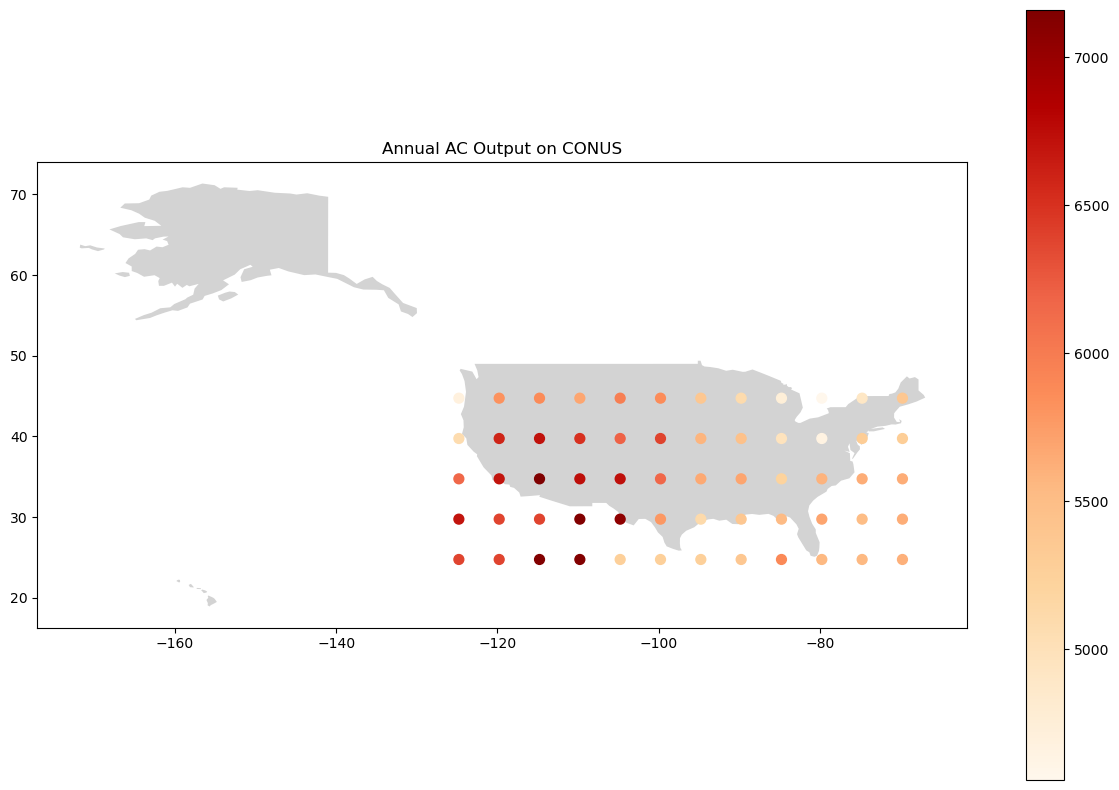

In [9]:
# Load US boundaries and plot
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[world.name == "United States of America"]

# Plot
fig, ax = plt.subplots(figsize=(15,10))
us.plot(ax=ax, color='lightgray')
geo_df.plot(ax=ax, column='ac_annual', legend=True, markersize=50, cmap='OrRd')  # Use the column parameter
plt.title("Annual AC Output on CONUS")
plt.show()

In [16]:
# {
  # "inputs": {
  #   "api_key": "DEMO_KEY",
  #   "azimuth": "180",
  #   "system_capacity": "4",
  #   "losses": "14",
  #   "array_type": "1",
  #   "module_type": "0",
  #   "gcr": "0.4",
  #   "dc_ac_ratio": "1.2",
  #   "inv_eff": "96.0",
  #   "radius": "0",
  #   "dataset": "nsrdb",
  #   "tilt": "10",
  #   "address": "boulder, co",
  #   "soiling": [
  #     12.0,
  #     4.0,
  #     45.0,
  #     23.0,
  #     9.0,
  #     99.0,
  #     67.0,
  #     12.54,
  #     54.0,
  #     9.0,
  #     0.0,
  #     7.6
  #   ],
  #   "albedo": "0.3",
  #   "bifaciality": "0.7"
  # },
  # "errors": [],
  # "warnings": [],
  # "version": "8.0.0",
  # "ssc_info": {
  #   "version": 275,
  #   "build": "Linux 64 bit GNU/C++ Oct  4 2022 03:10:07",
  #   "module": "pvwattsv8"
  # },
  # "station_info": {
  #   "lat": 40.0099983215332,
  #   "lon": -105.2600021362305,
  #   "elev": 1635.640014648438,
  #   "tz": -7.0,
  #   "location": "149190",
  #   "city": "",
  #   "state": "Colorado",
  #   "solar_resource_file": "149190.csv",
  #   "weather_data_source": "NSRDB PSM V3 GOES tmy-2020 3.2.0"
  # }